In [ ]:
# get rid of some chemprop warnings
# import warnings

# warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import os

import pandas as pd

# load the data
df = pd.read_csv('/home/s2861704/ppk/test_kin/prep_storage/K200_noCMF_TK.csv')

display(df.head())

In [ ]:

# pivot the dataframe to have the accession as columns
df = df.pivot(index="SMILES", columns="accession", values="pchembl_value_Mean")
# #df.columns.name = None
df.reset_index(inplace=True)
print(df.columns)

display(df)
#Teams message + delete smiles
# from data_lk import pivot_Papyrus_data
# df = pivot_Papyrus_data(data=df)
# display(df.head())

In [ ]:
# print(len(df))
# max_Nans = len(df) - 30
# print(max_Nans)

In [ ]:
# print(len(df))
# max_Nans = len(df) - 30
# print(max_Nans)
# df_noempty = df
# df_noempty = df_noempty.drop(list(df.columns[df.isna().sum() > max_Nans]), axis=1)
# df = df_noempty.copy()
# display(df)

In [ ]:
# print(df['P42679'].isna().sum())

In [ ]:
column_list = list(df.columns)
print (column_list)

In [ ]:
del column_list[0:1]
print(column_list)

In [ ]:
from qsprpred.data import QSPRDataset
from sklearn.impute import SimpleImputer

target_props = []
for target in column_list:
    target_props.append({'name': target, 'task': "REGRESSION"})

In [ ]:
print(target_props)

In [ ]:
targets_kinase200 = df.columns[1:42].tolist()
display(targets_kinase200)

In [ ]:
#General modules
import tqdm
import pandas as pd
import numpy as np

from pulp import *
from typing import List
from collections import defaultdict

#Chemistry modules
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.SimDivFilters import rdSimDivPickers

#ML modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances


#Function for assigning datapoints to clusters for the scaffold-based split
def assignPointsToClusters(picks,fps):
    """
    Assigns points to clusters based on the Tanimoto similarity between the points
    and the cluster centers.
    
    Parameters
    ----------
    picks : list
        The indices of the cluster centers
    fps : list
        The fingerprints of the points to be clustered

    Returns
    -------
    clusters : dict
        A dictionary mapping cluster indices to lists of point indices
    
    Notes
    -----
    This is a simple greedy algorithm that assigns points to the cluster with the
    highest Tanimoto similarity.  It is not guaranteed to find the global optimum.
    """

    clusters = defaultdict(list)
    # add the cluster centers to the clusters
    for i,idx in enumerate(picks):
        clusters[i].append(idx)
    
    # calculate the Tanimoto similarities between the cluster centers and the
    # other points
    sims = np.zeros((len(picks),len(fps)))
    for i in range(len(picks)):
        pick = picks[i]
        sims[i,:] = DataStructs.BulkTanimotoSimilarity(fps[pick],fps)
        sims[i,i] = 0
    
    # assign the points to clusters
    best = np.argmax(sims,axis=0)
    for i,idx in enumerate(best):
        if i not in picks:
            clusters[idx].append(i)
    
    return clusters

#Function for allocating the different clusters to groups for balanced dataset creation (https://chemrxiv.org/engage/api-gateway/chemrxiv/assets/orp/resource/item/624558fa804882433dffcb67/original/construction-of-balanced-chemically-dissimilar-training-validation-and-test-sets-for-machine-learning-on-molecular-datasets.pdf)
def balance_data_from_tasks_vs_clusters_array_pulp(tasks_vs_clusters_array,
                                              sizes = [1],
                                              equal_weight_perc_compounds_as_tasks = False,
                                              relative_gap = 0,
                                              time_limit_seconds = 60 * 60,
                                              max_N_threads = 1):
    """Linear programming function needed to balance the data while merging clusters

    Parameters
    ----------
    tasks_vs_clusters_array : 2D np.array
        - the cross-tabulation of the number of data points per cluster, per task.
        - columns represent unique clusters.
        - rows represent tasks, except the first row, which represents the number of records (or compounds).
        - Optionally, instead of the number of data points, the provided array may contain the *percentages*
            of data points _for the task across all clusters_ (i.e. each *row*, NOT column, may sum to 1).
        IMPORTANT: make sure the array has 2 dimensions, even if only balancing the number of data records,
            so there is only 1 row. This can be achieved by setting ndmin = 2 in the np.array function.
    sizes : list
        - list of the desired final sizes (will be normalised to fractions internally).
    equal_weight_perc_compounds_as_tasks : bool
        - if True, matching the % records will have the same weight as matching the % data of individual tasks.
        - if False, matching the % records will have a weight X times larger than the X tasks.
    relative_gap : float
        - the relative gap between the absolute optimal objective and the current one at which the solver
          stops and returns a solution. Can be very useful for cases where the exact solution requires
          far too long to be found to be of any practical use.
        - set to 0 to obtain the absolute optimal solution (if reached within the time_limit_seconds)
    time_limit_seconds : int
        - the time limit in seconds for the solver (by default set to 1 hour)
        - after this time, whatever solution is available is returned
    max_N_threads : int
        - the maximal number of threads to be used by the solver.
        - it is advisable to set this number as high as allowed by the available resources.
    
    Output
    ------
    List (of length equal to the number of columns of tasks_vs_clusters_array) of final cluster identifiers
        (integers, numbered from 1 to len(sizes)), mapping each unique initial cluster to its final cluster.
    Example: if sizes == [20, 10, 70], the output will be a list like [3, 3, 1, 2, 1, 3...], where
        '1' represents the final cluster of relative size 20, '2' the one of relative size 10, and '3' the 
        one of relative size 70.
    """
    # Calculate the fractions from sizes

    fractional_sizes = sizes / np.sum(sizes)

    S = len(sizes)

    # Normalise the data matrix
    tasks_vs_clusters_array = tasks_vs_clusters_array / tasks_vs_clusters_array.sum(axis = 1, keepdims = True)

    # Find the number of tasks + compounds (M) and the number of initial clusters (N)
    M, N = tasks_vs_clusters_array.shape
    if (S > N):
        errormessage = 'The requested number of new clusters to make ('+ str(S) + ') cannot be larger than the initial number of clusters (' + str(N) + '). Please review.'
        raise ValueError(errormessage)

    # Given matrix A (M x N) of fraction of data per cluster, assign each cluster to one of S final ML subsets,
    # so that the fraction of data per ML subset is closest to the corresponding fraction_size.
    # The weights on each ML subset (WML, S x 1) are calculated from fractional_sizes harmonic-mean-like.
    # The weights on each task (WT, M x 1) are calculated as requested by the user.
    # In the end: argmin SUM(ABS((A.X-T).WML).WT)
    # where X is the (N x S) binary solution matrix
    # where T is the (M x S) matrix of target fraction sizes (repeat of fractional_sizes)
    # constraint: assign one cluster to one and only one final ML subset
    # i.e. each row of X must sum to 1

    A = np.copy(tasks_vs_clusters_array)

    # Create WT = obj_weights
    if ((M > 1) & (equal_weight_perc_compounds_as_tasks == False)):
        obj_weights = np.array([M-1] + [1] * (M-1))
    else:
        obj_weights = np.array([1] * M)

    obj_weights = obj_weights / np.sum(obj_weights)

    # Create WML
    sk_harmonic = (1 / fractional_sizes) / np.sum(1 / fractional_sizes)

    # Create the pulp model
    prob = LpProblem("Data_balancing", LpMinimize)

    # Create the pulp variables
    # x_names represent clusters, ML_subsets, and are binary variables
    x_names = ['x_'+str(i) for i in range(N * S)]
    x = [LpVariable(x_names[i], lowBound = 0, upBound = 1, cat = 'Integer') for i in range(N * S)]
    # X_names represent tasks, ML_subsets, and are continuous positive variables
    X_names = ['X_'+str(i) for i in range(M * S)]
    X = [LpVariable(X_names[i], lowBound = 0, cat = 'Continuous') for i in range(M * S)]

    # Add the objective to the model

    obj = []
    coeff = []
    for m in range(S):
        for t in range(M):
            obj.append(X[m*M+t])
            coeff.append(sk_harmonic[m] * obj_weights[t])

    prob += LpAffineExpression([(obj[i],coeff[i]) for i in range(len(obj)) ])

    # Add the constraints to the model

    # Constraints forcing each cluster to be in one and only one ML_subset
    for c in range(N):
        prob += LpAffineExpression([(x[c+m*N],+1) for m in range(S)]) == 1

    # Constraints related to the ABS values handling, part 1 and 2
    for m in range(S):
        for t in range(M):
            cs = [c for c in range(N) if A[t,c] != 0]
            prob += LpAffineExpression([(x[c+m*N],A[t,c]) for c in cs]) - X[t] <= fractional_sizes[m]
            prob += LpAffineExpression([(x[c+m*N],A[t,c]) for c in cs]) + X[t] >= fractional_sizes[m]

    # Solve the model
    prob.solve(PULP_CBC_CMD(gapRel = relative_gap, timeLimit = time_limit_seconds, threads = max_N_threads))
    #solver.tmpDir = "/zfsdata/data/erik/erik-rp1/pQSAR/scaffoldsplit_trial/tmp"
    #prob.solve(solver)

    # Extract the solution

    list_binary_solution = [value(x[i]) for i in range(N * S)]
    list_initial_cluster_indices = [(list(range(N)) * S)[i] for i,l in enumerate(list_binary_solution) if l == 1]
    list_final_ML_subsets = [(list((1 + np.repeat(range(S), N)).astype('int64')))[i] for i,l in enumerate(list_binary_solution) if l == 1]
    mapping = [x for _, x in sorted(zip(list_initial_cluster_indices, list_final_ML_subsets))]

    return(mapping)

#Function for sorting targets based on amount of data
def order_targets_per_number_of_datapoints(data, targets):
    """
    Sorts the targets based on the amount of datapoints
    
    Parameters
    ----------
    data : pd.DataFrame
        Dataframe containing the data
    targets : list
        List of targets
        
    Returns
    -------
    list
        List of targets sorted based on the amount of datapoints
    """
    n_datapoints_per_target = {}
    for target in targets:
        n_datapoints_per_target[target] = data[target].count()
    n_datapoints_per_target = dict(sorted(n_datapoints_per_target.items(), key=lambda item: item[1], reverse=True))
    
    return list(n_datapoints_per_target.keys())
    
def random_global_equilibrated_random_split(data, targets, seed):
    """
    Random Global Equilibrated Split (RGES) is done by sorting targets from the target 
    with the most data points to those with the least. Then, for each target, a random split was made. 
    If a compound belonged to a different (train, validation, test) set for a different target, 
    its final label was set to the label of that compound for the target lowest on the sorted list. 
    This mechanism was chosen because reassigning labels for targets with larger numbers of compounds 
    has smaller relative effects on the balance. 
    
    Parameters
    ----------
    data : pd.DataFrame
        Dataframe containing the data
    targets : list
        List of targets
    seed : int
        Seed for the random split
    
    Returns
    -------
    pd.DataFrame
        Dataframe containing the data with a column 'Subset' containing the split"""
    
    print('Create RGES split...')

    ordered_targets = order_targets_per_number_of_datapoints(data, targets)
    
    split_data = data.copy()
    split_data['split'] = 0

    for target in tqdm.tqdm(ordered_targets, desc='Targets'):
        index = split_data[~split_data[target].isna()].index.tolist()
        print(target)
        train, test = train_test_split(index, test_size=1/10, random_state=seed)
        train, valid = train_test_split(train, test_size=1/9, random_state=seed)
        for i in train : split_data.loc[i, 'split'] = 'train'
        for i in valid : split_data.loc[i, 'split'] = 'test'
        for i in test : split_data.loc[i, 'split'] = 'test'

    return split_data

def dissimilaritydrive_global_balanced_cluster_split(data, targets, threads=8, sizes = [0.8,0.1,0.1]):

    """
    Dissimilarity-Driven Global Balanced Cluster Split (DGBC) is done using a method developed in 

    Tricarico, G. A.; Hofmans, J.; Lenselink, E. B.; López-Ramos, M.; Dréanic, M.-P.; Stouten, P. F. W. 
    Construction of balanced, chemically dissimilar training, validation and test sets for machine learning 
    on molecular datasets. 2022, ChemRxiv 2022. DOI: https://doi.org/10.26434/chemrxiv-2022-m8l33-v2. 

    Parameters
    ----------
    data : pd.DataFrame
        Dataframe containing the data
    targets : list
        List of targets
    threads : int
        Number of threads to use
    sizes : list
        List of floats containing the size of the train, validation and test set. Default is [0.8,0.1,0.1]

    Returns
    -------
    pd.DataFrame
        Dataframe containing the data with a column 'Subset' containing the split
    """

    print('Create DGBC split...')
    
    # Assign compounds to clusters
    split_data = data.copy().reset_index(drop=True)

    # Compute fingerprints
    fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 3, 2048) for s in split_data['SMILES']]

    # Get the cluster centers
    print("Pick cluster centers with Sayle's algorithm...")
    lead_picker = rdSimDivPickers.LeaderPicker()
    similarity_threshold = 0.736
    centroids_indices = lead_picker.LazyBitVectorPick(fps, len(fps), similarity_threshold)
    clusters = { i: [centroid_idx] for i, centroid_idx in enumerate(centroids_indices) }

    # Calculate the Tanimoto similarities between the cluster centers 
    # and the other points
    print('Calculating Tanimoto similarities between cluster centers and other points...')
    sims = np.zeros((len(centroids_indices),len(fps)))
    for i, centroid_idx in enumerate(centroids_indices):
        sims[i,:] = DataStructs.BulkTanimotoSimilarity(fps[centroid_idx],fps)
        # sims[i,i] = 0

    # Assign the points to clusters
    print('Assigning points to clusters...')
    best_cluster = np.argmax(sims,axis=0) # shape of best_cluster is (len(fps),)
    for i, idx in enumerate(best_cluster):
        if i not in centroids_indices:
            clusters[idx].append(i)
    
    # # Compute the amount of data per target per cluster
    # # Shape of taks_vs_clusters_array is (n_targets+1, n_clusters)
    target_vs_clusters = np.zeros((len(targets)+1, len(clusters)))
    target_vs_clusters[0,:] = [ len(cluster) for cluster in clusters.values() ]

    for i, target in enumerate(targets):
        for j, indices_per_cluster in clusters.items():
            data_per_cluster = split_data.iloc[indices_per_cluster]
            target_vs_clusters[i+1,j] = data_per_cluster[target].dropna().shape[0]

    print(target_vs_clusters.shape, len(clusters))

    # Balance the data per target per cluster using PuLP and return the mapping of clusters to subsets (train, validation, test)
    mapping = balance_data_from_tasks_vs_clusters_array_pulp(target_vs_clusters,
                                            sizes = sizes,
                                            equal_weight_perc_compounds_as_tasks = False,
                                            relative_gap = 0,
                                            time_limit_seconds = 60 * 60,
                                            max_N_threads = threads,
                                            )

    for i, idx in clusters.items(): 
        if mapping[i] == 1 :
            split_data.loc[idx, 'split'] = 'train'
        elif mapping[i] == 2 :
            split_data.loc[idx, 'split'] = 'test'
        elif mapping[i] == 3 :
            split_data.loc[idx, 'split'] = 'test'
    
    return split_data

def print_balance_metrics(data : pd.DataFrame, targets : List[str]):
    """ 
    Print the balance metrics for the given subsets and targets.
    """
        
    txt = 'Overall balance:'
    for subset in sorted(data['split'].unique()):
        n = len(data[data['split'] == subset])
        frac = n/ len(data)
        txt += f' {subset}: {n} ({frac:05.2%})'
    print(txt)
    
    for target in targets:
        txt = f'{target} balance:'
        df = data.dropna(subset=[target])
        for subset in sorted(data['split'].unique()):
            n = len(df[df['split'] == subset])
            frac = n / len(df)
            txt += f' {subset}: {n} ({frac:05.2%})'
        print(txt)
    
def compute_intersubset_Tanimoto_distance(df, n_jobs=1):
    """
    Compute the minimum Tanimoto distance per compound to the compounds in the other subsets.
    
    Parameters
    ----------
    data : pd.DataFrame
        Dataframe containing the data with a column 'Subset' containing the split
    smiles_column : str, optional
        Name of the column containing the SMILES, by default 'SMILES'
    
    Returns
    -------
    pd.DataFrame
        Dataframe containing the data with a column 'MinInterSetTd' containing the minimum Tanimoto distance

    """

    df.reset_index(drop=True, inplace=True)

    # Compute Morgan Fingerprints
    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 3, nBits=2048) for s in df.SMILES]

    # Compute pairwise Tanimoto distances between all compounds
    dists = pairwise_distances(np.array(fps), metric='jaccard', n_jobs=n_jobs)

    for idx, row in tqdm.tqdm(df.iterrows(), total=df.shape[0], desc='Computing minimum Tanimoto distance'):
        subset = row['split']
        other_subset_indices = df[df['split'] != subset].index.values
        min_dist = min([dists[idx, i] for i in other_subset_indices])
        df.loc[idx, 'MinInterSetTd'] = min_dist

    # Print average and std  of minimum distances per subset
    txt = 'Average and std of minimum Tanimoto distance per subset:'
    for subset in sorted(df['split'].unique()):
        dist = df[df['split'] == subset]['MinInterSetTd'].to_numpy()
        txt += f' {subset}: {np.mean(dist):.2f} ({np.std(dist):.2f})'
    print(txt)

    return df


In [ ]:
from qsprpred.data import QSPRDataset, RandomSplit
from qsprpred.data.descriptors.fingerprints import MorganFP
from qsprpred.data.descriptors.sets import SmilesDesc
from qsprpred.data.sampling.splits import GBMTRandomSplit, GBMTDataSplit
# from split import random_global_equilibrated_random_split, dissimilaritydrive_global_balanced_cluster_split

df = random_global_equilibrated_random_split(data=df, targets=targets_kinase200, seed=2025)
# df = dissimilaritydrive_global_balanced_cluster_split(data=df, targets=targets_kinase200, threads=8, sizes=[0.8,0.1,0.1])

In [ ]:
display(df)
print(df['split'].unique())
print(len(df[df['split']==0]))
print(len(df[df['split']=='train']))
print(len(df[df['split']=='test']))
df.to_csv(path_or_buf='/home/s2861704/ppk/test_kin/output/TK/TK_split.csv', sep=',', index=False)

In [1]:
#reload packages for df reload

import os
import pandas as pd
from qsprpred.data import QSPRDataset
from sklearn.impute import SimpleImputer
from qsprpred.data import QSPRDataset, RandomSplit
from qsprpred.data.descriptors.fingerprints import MorganFP
from qsprpred.data.descriptors.sets import SmilesDesc
from qsprpred.data.sampling.splits import GBMTRandomSplit, GBMTDataSplit, ManualSplit
from split import random_global_equilibrated_random_split, dissimilaritydrive_global_balanced_cluster_split

In [2]:
df=pd.read_csv('/home/s2861704/ppk/test_kin/output/TK/TK_split.csv', sep=',')

column_list = list(df.columns[1:42])
# del column_list[0:1]
target_props = []
for target in column_list:
    target_props.append({'name': target, 'task': "REGRESSION"})
print(target_props)

[{'name': 'O60674', 'task': 'REGRESSION'}, {'name': 'P00519', 'task': 'REGRESSION'}, {'name': 'P00533', 'task': 'REGRESSION'}, {'name': 'P04626', 'task': 'REGRESSION'}, {'name': 'P04629', 'task': 'REGRESSION'}, {'name': 'P06213', 'task': 'REGRESSION'}, {'name': 'P06239', 'task': 'REGRESSION'}, {'name': 'P07333', 'task': 'REGRESSION'}, {'name': 'P07949', 'task': 'REGRESSION'}, {'name': 'P08069', 'task': 'REGRESSION'}, {'name': 'P08581', 'task': 'REGRESSION'}, {'name': 'P09581', 'task': 'REGRESSION'}, {'name': 'P09619', 'task': 'REGRESSION'}, {'name': 'P10721', 'task': 'REGRESSION'}, {'name': 'P11362', 'task': 'REGRESSION'}, {'name': 'P12931', 'task': 'REGRESSION'}, {'name': 'P16234', 'task': 'REGRESSION'}, {'name': 'P17948', 'task': 'REGRESSION'}, {'name': 'P21802', 'task': 'REGRESSION'}, {'name': 'P22455', 'task': 'REGRESSION'}, {'name': 'P22607', 'task': 'REGRESSION'}, {'name': 'P23458', 'task': 'REGRESSION'}, {'name': 'P29317', 'task': 'REGRESSION'}, {'name': 'P29597', 'task': 'REGRE

In [3]:
dataset = QSPRDataset(
    name="ChempropMTTKDataset",
    df=df,
    target_props=target_props,
    store_dir="/home/s2861704/ppk/test_kin/output/TK/MTcust/data",
    random_state=42,
    drop_empty=False,
    overwrite=True
)

dataset.getDF()

SMILES  \
QSPRID                                                                         
ChempropMTTKDataset_00000               BrC(Cn1ncc2c(N3CCCC3)ncnc21)c1ccccc1   
ChempropMTTKDataset_00001              BrC(Cn1ncc2c(N3CCCCC3)ncnc21)c1ccccc1   
ChempropMTTKDataset_00002            BrC(Cn1ncc2c(NCc3ccccc3)ncnc21)c1ccccc1   
ChempropMTTKDataset_00003      Brc1cc(CNc2ncc(Br)c(Nc3cc(C4CC4)[nH]n3)n2)on1   
ChempropMTTKDataset_00004                        Brc1cc2c(NCc3ccccc3)ncnc2s1   
...                                                                      ...   
ChempropMTTKDataset_36999  c1nc2c(Nc3ccc(N4CCOCC4)cc3)nc(-c3ccc4c[nH]nc4c...   
ChempropMTTKDataset_37000  c1nc2c(Nc3ccc(N4CCOCC4)cc3)nc(-c3ccc4c[nH]nc4c...   
ChempropMTTKDataset_37001  c1ncc(-c2cc(CNc3nc(Nc4cc(C5CC5)[nH]n4)cc(N4CCO...   
ChempropMTTKDataset_37002         c1ncc(CN2CCC(n3cnc4cnc5[nH]ccc5c43)CC2)cn1   
ChempropMTTKDataset_37003                            c1nnc2nnc(N3CCOCC3)nn12   

                           O60674  P00519  P00533  P04626  P04629  P06213  \
QSPRID                                                                      
ChempropMTTKDataset_00000     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00001     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00002     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00003     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00004     NaN     NaN    6.62     NaN     NaN     NaN   
...                           ...     ...     ...     ...     ...     ...   
ChempropMTTKDataset_36999     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_37000     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_37001     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_37002     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_37003     NaN     NaN     NaN     NaN     NaN     NaN   

                           P06239  P07333  P07949  ...  Q05397_original  \
QSPRID                                             ...                    
ChempropMTTKDataset_00000     NaN     NaN     NaN  ...              NaN   
ChempropMTTKDataset_00001     NaN     NaN     NaN  ...              NaN   
ChempropMTTKDataset_00002     NaN     NaN     NaN  ...              NaN   
ChempropMTTKDataset_00003     NaN     NaN     NaN  ...              NaN   
ChempropMTTKDataset_00004     NaN     NaN     NaN  ...              NaN   
...                           ...     ...     ...  ...              ...   
ChempropMTTKDataset_36999     NaN     NaN     NaN  ...              NaN   
ChempropMTTKDataset_37000     NaN     NaN     NaN  ...              NaN   
ChempropMTTKDataset_37001     NaN     NaN     NaN  ...              NaN   
ChempropMTTKDataset_37002     NaN     NaN     NaN  ...              NaN   
ChempropMTTKDataset_37003     NaN     NaN     NaN  ...              NaN   

                           Q06187_original  Q06418_original  Q07912_original  \
QSPRID                                                                         
ChempropMTTKDataset_00000              NaN              NaN              NaN   
ChempropMTTKDataset_00001              NaN              NaN              NaN   
ChempropMTTKDataset_00002              NaN              NaN              NaN   
ChempropMTTKDataset_00003              NaN              NaN              NaN   
ChempropMTTKDataset_00004              NaN              NaN              NaN   
...                                    ...              ...              ...   
ChempropMTTKDataset_36999             6.43              NaN              NaN   
ChempropMTTKDataset_37000             7.14              NaN              NaN   
ChempropMTTKDataset_37001              NaN              NaN              NaN   
ChempropMTTKDataset_37002              NaN              NaN              NaN   
ChempropMTTKDataset_37003              NaN              NaN              NaN   

          

In [4]:

feature_calculators = [SmilesDesc(), MorganFP(radius=3, nBits=2048)]
dataset.prepareDataset(
    # split=random_global_equilibrated_random_split(data=df, targets=targets_kinase200, seed=2025),
    split=ManualSplit(splitcol=dataset.df["split"], trainval="train", testval="test"),
    feature_calculators=feature_calculators,
    recalculate_features=True,
)

dataset.getDF().head()

SMILES  \
QSPRID                                                                     
ChempropMTTKDataset_00000           BrC(Cn1ncc2c(N3CCCC3)ncnc21)c1ccccc1   
ChempropMTTKDataset_00001          BrC(Cn1ncc2c(N3CCCCC3)ncnc21)c1ccccc1   
ChempropMTTKDataset_00002        BrC(Cn1ncc2c(NCc3ccccc3)ncnc21)c1ccccc1   
ChempropMTTKDataset_00003  Brc1cc(CNc2ncc(Br)c(Nc3cc(C4CC4)[nH]n3)n2)on1   
ChempropMTTKDataset_00004                    Brc1cc2c(NCc3ccccc3)ncnc2s1   

                           O60674  P00519  P00533  P04626  P04629  P06213  \
QSPRID                                                                      
ChempropMTTKDataset_00000     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00001     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00002     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00003     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00004     NaN     NaN    6.62     NaN     NaN     NaN   

                           P06239  P07333  P07949  ...  Q05397_original  \
QSPRID                                             ...                    
ChempropMTTKDataset_00000     NaN     NaN     NaN  ...              NaN   
ChempropMTTKDataset_00001     NaN     NaN     NaN  ...              NaN   
ChempropMTTKDataset_00002     NaN     NaN     NaN  ...              NaN   
ChempropMTTKDataset_00003     NaN     NaN     NaN  ...              NaN   
ChempropMTTKDataset_00004     NaN     NaN     NaN  ...              NaN   

                           Q06187_original  Q06418_original  Q07912_original  \
QSPRID                                                                         
ChempropMTTKDataset_00000              NaN              NaN              NaN   
ChempropMTTKDataset_00001              NaN              NaN              NaN   
ChempropMTTKDataset_00002              NaN              NaN              NaN   
ChempropMTTKDataset_00003              NaN              NaN              NaN   
ChempropMTTKDataset_00004              NaN              NaN              NaN   

                           Q08345_original  Q08881_original  Q12866_original  \
QSPRID                                                                         
ChempropMTTKDataset_00000              NaN              NaN              NaN   
ChempropMTTKDataset_00001              NaN              NaN              NaN   
ChempropMTTKDataset_00002              NaN              NaN              NaN   
ChempropMTTKDataset_00003              NaN              NaN              NaN   
ChempropMTTKDataset_00004              NaN              NaN              NaN   

                           Q16288_original  Q16620_original  Q16832_original  
QSPRID                                                                        
ChempropMTTKDataset_00000              NaN              NaN              NaN  
ChempropMTTKDataset_00001              NaN              NaN              NaN  
ChempropMTTKDataset_00002              NaN              NaN              NaN  
ChempropMTTKDataset_00003              NaN              NaN              NaN  
ChempropMTTKDataset_00004              NaN              NaN              NaN  

[5 rows x 85 columns]

In [5]:
from qsprpred.extra.gpu.models.chemprop import ChempropModel

ChempropModel.getAvailableParameters()

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


{'no_cuda': 'Turn off cuda (i.e., use CPU instead of GPU).',
 'gpu': 'Which GPU to use.',
 'num_workers': 'Number of workers for the parallel data loading (0 means sequential).',
 'batch_size': 'Batch size.',
 'no_cache_mol': 'Whether to not cache the RDKit molecule for each SMILES string to reduce memory usage (cached by default).',
 'empty_cache': 'Whether to empty all caches before training or predicting. This is necessary if multiple jobs are run within a single script and the atom or bond features change.',
 'loss_function': 'Choice of loss function. Loss functions are limited to compatible dataset types.',
 'metric': "Metric to use with the validation set for early stopping. Defaults to 'auc' for classification, 'rmse' for regression. Note. In Chemprop this metric is also used for test-set evaluation, but in QSPRpred this is determined by the scoring parameter in assessment.",
 'bias': 'Whether to add bias to linear layers.',
 'hidden_size': 'Dimensionality of hidden layers in MP

In [6]:
# Create model
os.makedirs("/home/s2861704/ppk/test_kin/output/TK/MTcust/models", exist_ok=True)
model = ChempropModel(
    base_dir='/home/s2861704/ppk/test_kin/output/TK/MTcust/models',
    name='ChempropMTTKModel',
    parameters={"hidden_size":300, "depth":3, "dropout":0.05, "ffn_num_layers":300, "activation":"ReLU", "bias":False, "max_lr":1e-3, "epochs":50},
    quiet_logger=False
)

In [7]:
from qsprpred.models import SklearnMetrics, MaskedMetric
from qsprpred.plotting import regression
from qsprpred.tasks import ModelTasks
import numpy as np

r2_score=SklearnMetrics('r2')
masked_metric=MaskedMetric(metric=SklearnMetrics('r2'))

In [8]:
from abc import ABC, abstractmethod
from datetime import datetime
from typing import Callable, Iterable

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold

from qsprpred.models.assessment.metrics.scikit_learn import SklearnMetrics
from qsprpred.data import QSPRDataset
from qsprpred.data.sampling.splits import DataSplit
from qsprpred.logs import logger
from qsprpred.models.early_stopping import EarlyStoppingMode
from qsprpred.models.model import QSPRModel
from qsprpred.models.monitors import AssessorMonitor, BaseMonitor

class ModelAssessor(ABC):
    """Base class for assessment methods.

    Attributes:
        scoreFunc (Metric): scoring function to use, should match the output of the
                        evaluation method (e.g. if the evaluation methods returns
                        class probabilities, the scoring function support class
                        probabilities)
        monitor (AssessorMonitor): monitor to use for assessment, if None, a BaseMonitor
            is used
        useProba (bool): use probabilities for classification models
        mode (EarlyStoppingMode): early stopping mode for fitting
        splitMultitaskScores (bool): whether to split the scores per task for multitask models
    """

    def __init__(
            self,
            scoring: str | Callable[[Iterable, Iterable], float],
            monitor: AssessorMonitor | None = None,
            use_proba: bool = True,
            mode: EarlyStoppingMode | None = None,
            split_multitask_scores: bool = False,
    ):
        """Initialize the evaluation method class.

        Args:
            scoring: str | Callable[[Iterable, Iterable], float],
            monitor (AssessorMonitor): monitor to track the evaluation
            use_proba (bool): use probabilities for classification models
            mode (EarlyStoppingMode): early stopping mode for fitting
            split_multitask_scores (bool): whether to split the scores per task for multitask models
        """
        self.monitor = monitor
        self.useProba = use_proba
        self.mode = mode
        self.scoreFunc = (
            SklearnMetrics(scoring) if isinstance(scoring, str) else scoring
        )
        self.splitMultitaskScores = split_multitask_scores

    @abstractmethod
    def __call__(
            self,
            model: QSPRModel,
            ds: QSPRDataset,
            save: bool = True,
            parameters: dict | None = None,
            monitor: AssessorMonitor | None = None,
            **kwargs,
    ) -> np.ndarray:
        """Evaluate the model.

        Args:
            model (QSPRModel): model to evaluate
            ds (QSPRDataset): dataset to evaluate on
            save (bool): save predictions to file
            parameters (dict): parameters to use for the evaluation
            monitor (AssessorMonitor): monitor to track the evaluation, overrides
                                       the monitor set in the constructor
            kwargs: additional arguments for fit function of the model

        Returns:
            np.ndarray: scores for the model. If splitMultitaskScores is True, each
            column represents a task and each row a fold. Otherwise, a 1D array is
            returned with the scores for each fold.
        """

    def predictionsToDataFrame(
            self,
            model: QSPRModel,
            y: np.array,
            predictions: np.ndarray | list[np.ndarray],
            index: pd.Series,
            extra_columns: dict[str, np.ndarray] | None = None,
    ) -> pd.DataFrame:
        """Create a dataframe with true values and predictions.

        Args:
            model (QSPRModel): model to evaluate
            y (np.array): target values
            predictions (np.ndarray | list[np.ndarray]): predictions
            index (pd.Series): index of the data set
            extra_columns (dict[str, np.ndarray]): extra columns to add to the output
        """
        # Create dataframe with true values
        df_out = pd.DataFrame(
            y.values, columns=y.add_suffix("_Label").columns, index=index
        )
        # Add predictions to dataframe
        for idx, prop in enumerate(model.targetProperties):
            if prop.task.isClassification() and self.useProba:
                # convert one-hot encoded predictions to class labels
                # and add to train and test
                df_out[f"{prop.name}_Prediction"] = np.argmax(predictions[idx], axis=1)
                # add probability columns to train and test set
                df_out = pd.concat(
                    [
                        df_out,
                        pd.DataFrame(predictions[idx], index=index).add_prefix(
                            f"{prop.name}_ProbabilityClass_"
                        ),
                    ],
                    axis=1,
                )
            else:
                df_out[f"{prop.name}_Prediction"] = predictions[:, idx]
        # Add extra columns to dataframe if given (such as fold indexes)
        if extra_columns is not None:
            for col_name, col_values in extra_columns.items():
                df_out[col_name] = col_values
        return df_out
class CrossValAssessor(ModelAssessor):
    """Perform cross validation on a model.

    Attributes:
        useProba (bool): use predictProba instead of predict for classification
        monitor (AssessorMonitor): monitor to use for assessment, if None, a BaseMonitor
            is used
        mode (EarlyStoppingMode): mode to use for early stopping
        split (DataSplit): split to use for cross validation (default: KFold, n_splits=5)
        round (int): number of decimal places to round predictions to (default: 5)
        splitMultitaskScores (bool): whether to split the scores per task for multitask models
    """

    def __init__(
            self,
            scoring: str | Callable[[Iterable, Iterable], float],
            split: DataSplit | None = None,
            monitor: AssessorMonitor | None = None,
            use_proba: bool = True,
            mode: EarlyStoppingMode | None = None,
            round: int = 5,
            split_multitask_scores: bool = False,
    ):
        super().__init__(scoring, monitor, use_proba, mode, split_multitask_scores)
        self.split = split
        if monitor is None:
            self.monitor = BaseMonitor()
        self.round = round

    def __call__(
            self,
            model: QSPRModel,
            ds: QSPRDataset,
            save: bool = True,
            parameters: dict | None = None,
            monitor: AssessorMonitor | None = None,
            **kwargs,
    ) -> np.ndarray:
        """Perform cross validation on the model with the given parameters.

        Arguments:
            model (QSPRModel): model to assess
            ds (QSPRDataset): dataset to assess on
            scoring (str | Callable): scoring function to use
            save (bool): whether to save predictions to file
            parameters (dict): optional model parameters to use in assessment
            monitor (AssessorMonitor): optional, overrides monitor set in constructor
            **kwargs: additional keyword arguments for the fit function

        Returns:
            np.ndarray: scores for the validation sets. If splitMultitaskScores is True, each
            column represents a task and each row a fold. Otherwise, a 1D array is
            returned with the scores for each fold.
        """
        model.initFromDataset(ds)
        monitor = monitor or self.monitor
        split = self.split or KFold(
            n_splits=5, shuffle=True, random_state=model.randomState
        )
        evalparams = model.parameters if parameters is None else parameters
        X, _ = ds.getFeatures()
        y, _ = ds.getTargetPropertiesValues()
        monitor.onAssessmentStart(model, ds, self.__class__.__name__)
        # cross validation
        fold_counter = np.zeros(y.shape[0])
        predictions = []
        scores = []
        for i, (X_train, X_test, y_train, y_test, idx_train, idx_test) in enumerate(
                ds.iterFolds(split=split)
        ):
            logger.debug(
                "cross validation fold %s started: %s"
                % (i, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
            )
            monitor.onFoldStart(
                fold=i, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
            )
            # fit model
            crossval_estimator = model.loadEstimator(evalparams)
            print(y_train)
            model_fit = model.fit(
                X_train,
                y_train,
                crossval_estimator,
                self.mode,
                monitor=monitor,
                **kwargs,
            )
            # make predictions
            if model.task.isRegression() or not self.useProba:
                fold_predictions = model.predict(X_test, crossval_estimator)
            else:
                fold_predictions = model.predictProba(X_test, crossval_estimator)
            # score
            if model.isMultiTask and self.splitMultitaskScores:
                scores_tasks = []
                for idx, prop in enumerate(model.targetProperties):
                    if self.useProba and prop.task.isClassification():
                        prop_predictions = [fold_predictions[idx]]
                        scores_tasks.append(
                            self.scoreFunc(y.iloc[idx_test, idx], prop_predictions)
                        )
                    else:
                        scores_tasks.append(
                            self.scoreFunc(
                                y.iloc[idx_test, idx], fold_predictions[:, idx]
                            )
                        )
                scores.append(scores_tasks)
            else:
                score = self.scoreFunc(y.iloc[idx_test], fold_predictions)
                scores.append(score)
            # save molecule ids and fold number
            fold_counter[idx_test] = i
            logger.debug(
                "cross validation fold %s ended: %s"
                % (i, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
            )
            fold_predictions_df = self.predictionsToDataFrame(
                model,
                y.iloc[idx_test],
                fold_predictions,
                pd.Series(y.index).iloc[idx_test],
                extra_columns={"Fold": fold_counter[idx_test]},
            )
            monitor.onFoldEnd(model_fit, fold_predictions_df)
            predictions.append(fold_predictions_df)
        # save results
        if save:
            pd.concat(predictions).round(self.round).to_csv(
                f"{model.outPrefix}.cv.tsv", sep="\t"
            )
        monitor.onAssessmentEnd(pd.concat(predictions))
        return np.array(scores)
class TestSetAssessor(ModelAssessor):
    """Assess a model on a test set.

    Attributes:+
        useProba (bool): use predictProba instead of predict for classification
        monitor (AssessorMonitor): monitor to use for assessment, if None, a BaseMonitor
            is used
        mode (EarlyStoppingMode): mode to use for early stopping
        round (int): number of decimal places to round predictions to (default: 3)
        splitMultitaskScores (bool): whether to split the scores per task for multitask models
    """

    def __init__(
            self,
            scoring: str | Callable[[Iterable, Iterable], float],
            monitor: AssessorMonitor | None = None,
            use_proba: bool = True,
            mode: EarlyStoppingMode | None = None,
            round: int = 5,
            split_multitask_scores: bool = False,
    ):
        super().__init__(scoring, monitor, use_proba, mode, split_multitask_scores)
        if monitor is None:
            self.monitor = BaseMonitor()
        self.round = round

    def __call__(
            self,
            model: QSPRModel,
            ds: QSPRDataset,
            save: bool = True,
            parameters: dict | None = None,
            monitor: AssessorMonitor | None = None,
            **kwargs,
    ) -> np.ndarray:
        """Make predictions for independent test set.

        Arguments:
            model (QSPRModel): model to assess
            ds (QSPRDataset): dataset to assess on
            scoring (str | Callable): scoring function to use
            save (bool): whether to save predictions to file
            parameters (dict): optional model parameters to use in assessment
            use_proba (bool): use predictProba instead of predict for classification
            monitor (AssessorMonitor): optional, overrides monitor set in constructor
            **kwargs: additional keyword arguments for the fit function

        Returns:
            np.ndarray: scores for the test set. If splitMultitaskScores is True, each
            column represents a task. Otherwise, a 1D array is returned with the score
            for the test set.
        """
        model.initFromDataset(ds)
        monitor = monitor or self.monitor
        evalparams = model.parameters if parameters is None else parameters
        X, X_ind = ds.getFeatures()
        y, y_ind = ds.getTargetPropertiesValues()
        monitor.onAssessmentStart(model, ds, self.__class__.__name__)
        monitor.onFoldStart(fold=0, X_train=X, y_train=y, X_test=X_ind, y_test=y_ind)
        # fit model
        ind_estimator = model.loadEstimator(evalparams)
        ind_estimator = model.fit(
            X, y, ind_estimator, self.mode, monitor=monitor, **kwargs
        )
        # predict values for independent test set
        if model.task.isRegression() or not self.useProba:
            predictions = model.predict(X_ind, ind_estimator)
        else:
            predictions = model.predictProba(X_ind, ind_estimator)
        # score
        try:
            if model.isMultiTask and self.splitMultitaskScores:
                scores_tasks = []
                for idx, prop in enumerate(model.targetProperties):
                    if self.useProba and prop.task.isClassification():
                        prop_predictions = [predictions[idx]]
                        scores_tasks.append(
                            self.scoreFunc(y_ind.iloc[:, idx], prop_predictions)
                        )
                    else:
                        scores_tasks.append(
                            self.scoreFunc(y_ind.iloc[:, idx], predictions[:, idx])
                        )
                score = scores_tasks
            else:
                score = [self.scoreFunc(y_ind, predictions)]
            predictions_df = self.predictionsToDataFrame(
                model, y_ind, predictions, y_ind.index
            )
            monitor.onFoldEnd(ind_estimator, predictions_df)
            # predict values for independent test set and save results
            if save:
                predictions_df.round(self.round).to_csv(
                    f"{model.outPrefix}.ind.tsv", sep="\t"
                )
            monitor.onAssessmentEnd(predictions_df)
            return np.array(score)
        except:
            print("Error is caused by either ... or by ...")
            print(X_ind)
            print(prop)
            print(idx)
            print(y_ind.iloc[:, idx])
            print(np.shape(predictions))
            print(predictions[:, idx])


In [9]:
# from qsprpred.models import CrossValAssessor
#, TestSetAssessor
from qsprpred.models.early_stopping import EarlyStoppingMode

# We can now assess the model performance on the training set using cross validation
CrossValAssessor(masked_metric, split_multitask_scores=True)(model, dataset)

# and on the test set
TestSetAssessor(masked_metric, split_multitask_scores=True)(model, dataset)

# Finally, we need to fit the model on the complete dataset if we want to use it further
# This will save the fitted model and metadata to disk
model.earlyStopping.numEpochs = 20
model.fitDataset(dataset, mode=EarlyStoppingMode.FIXED)

# We can optionally save the model and metadata to disk explicitly as well
_ = model.save()

qsprpred - WARNING - Random state supplied, but alg <class 'qsprpred.extra.gpu.models.chemprop.ChempropMoleculeModel'> does not support it. Ignoring this setting.


                           O60674  P00519  P00533  P04626  P04629  P06213  \
QSPRID                                                                      
ChempropMTTKDataset_00000     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00001     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00002     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00003     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00004     NaN     NaN    6.62     NaN     NaN     NaN   
...                           ...     ...     ...     ...     ...     ...   
ChempropMTTKDataset_36999     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_37000     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_37001     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_37002     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_37003     NaN     NaN     NaN     NaN     NaN     NaN   

train size = 21,337 | val size = 2,371
Total size = 23,708
Fitting scaler
Number of parameters = 27,276,641
Moving trained model to cuda
  0%|          | 0/50 [00:00<?, ?it/s]Epoch 0
Loss = 9.6693e-01, PNorm = 301.0781, GNorm = 0.3658, lr_0 = 1.1162e-04
Loss = 9.5864e-01, PNorm = 301.0781, GNorm = 0.4642, lr_0 = 1.2218e-04
Loss = 1.0001e+00, PNorm = 301.0776, GNorm = 0.4130, lr_0 = 1.3275e-04
Loss = 9.4490e-01, PNorm = 301.0772, GNorm = 0.2961, lr_0 = 1.4331e-04
Loss = 9.6386e-01, PNorm = 301.0773, GNorm = 0.3027, lr_0 = 1.5387e-04
Loss = 1.1312e+00, PNorm = 301.0775, GNorm = 0.2560, lr_0 = 1.6444e-04
Loss = 9.3899e-01, PNorm = 301.0770, GNorm = 0.2652, lr_0 = 1.7500e-04
Loss = 1.0363e+00, PNorm = 301.0765, GNorm = 0.3817, lr_0 = 1.8556e-04
Loss = 8.8538e-01, PNorm = 301.0764, GNorm = 0.3069, lr_0 = 1.9613e-04
Loss = 9.9708e-01, PNorm = 301.0765, GNorm = 0.3587, lr_0 = 2.0669e-04
Loss = 9.4099e-01, PNorm = 301.0767, GNorm = 0.3212, lr_0 = 2.1725e-04
Loss = 1.0054e+00, PNorm = 301.0770,

                           O60674  P00519  P00533  P04626  P04629  P06213  \
QSPRID                                                                      
ChempropMTTKDataset_00001     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00002     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00004     NaN     NaN   6.620     NaN     NaN     NaN   
ChempropMTTKDataset_00005     NaN     NaN   5.100     NaN     NaN     NaN   
ChempropMTTKDataset_00006     NaN     NaN   5.860     NaN     NaN     NaN   
...                           ...     ...     ...     ...     ...     ...   
ChempropMTTKDataset_36996     NaN     NaN   6.222     NaN     NaN     NaN   
ChempropMTTKDataset_36997     NaN     NaN   6.903     NaN     NaN     NaN   
ChempropMTTKDataset_37000     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_37002     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_37003     NaN     NaN     NaN     NaN     NaN     NaN   

train size = 21,337 | val size = 2,371
Total size = 23,708
Fitting scaler
Number of parameters = 27,276,641
Moving trained model to cuda
  0%|          | 0/50 [00:00<?, ?it/s]Epoch 0
Loss = 9.8992e-01, PNorm = 301.0782, GNorm = 0.3740, lr_0 = 1.1162e-04
Loss = 1.0443e+00, PNorm = 301.0781, GNorm = 0.3337, lr_0 = 1.2218e-04
Loss = 1.0392e+00, PNorm = 301.0780, GNorm = 0.3398, lr_0 = 1.3275e-04
Loss = 1.0473e+00, PNorm = 301.0776, GNorm = 0.3961, lr_0 = 1.4331e-04
Loss = 1.0146e+00, PNorm = 301.0773, GNorm = 0.4325, lr_0 = 1.5387e-04
Loss = 9.1172e-01, PNorm = 301.0769, GNorm = 0.2270, lr_0 = 1.6444e-04
Loss = 1.0054e+00, PNorm = 301.0766, GNorm = 0.4087, lr_0 = 1.7500e-04
Loss = 9.6505e-01, PNorm = 301.0765, GNorm = 0.3107, lr_0 = 1.8556e-04
Loss = 9.9125e-01, PNorm = 301.0764, GNorm = 0.3334, lr_0 = 1.9613e-04
Loss = 9.9883e-01, PNorm = 301.0764, GNorm = 0.3483, lr_0 = 2.0669e-04
Loss = 1.0455e+00, PNorm = 301.0764, GNorm = 0.3524, lr_0 = 2.1725e-04
Loss = 1.0381e+00, PNorm = 301.0762,

                           O60674  P00519  P00533  P04626  P04629  P06213  \
QSPRID                                                                      
ChempropMTTKDataset_00000     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00001     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00002     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00003     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00006     NaN     NaN   5.860     NaN     NaN     NaN   
...                           ...     ...     ...     ...     ...     ...   
ChempropMTTKDataset_36996     NaN     NaN   6.222     NaN     NaN     NaN   
ChempropMTTKDataset_36999     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_37000     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_37001     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_37002     NaN     NaN     NaN     NaN     NaN     NaN   

train size = 21,337 | val size = 2,371
Total size = 23,708
Fitting scaler
Number of parameters = 27,276,641
Moving trained model to cuda
  0%|          | 0/50 [00:00<?, ?it/s]Epoch 0
Loss = 9.5573e-01, PNorm = 301.0780, GNorm = 0.3411, lr_0 = 1.1162e-04
Loss = 1.0728e+00, PNorm = 301.0776, GNorm = 0.3241, lr_0 = 1.2218e-04
Loss = 8.9633e-01, PNorm = 301.0772, GNorm = 0.3448, lr_0 = 1.3275e-04
Loss = 9.1949e-01, PNorm = 301.0771, GNorm = 0.3818, lr_0 = 1.4331e-04
Loss = 1.0616e+00, PNorm = 301.0771, GNorm = 0.3234, lr_0 = 1.5387e-04
Loss = 9.0249e-01, PNorm = 301.0771, GNorm = 0.3356, lr_0 = 1.6444e-04
Loss = 1.0838e+00, PNorm = 301.0771, GNorm = 0.3878, lr_0 = 1.7500e-04
Loss = 1.0588e+00, PNorm = 301.0768, GNorm = 0.3632, lr_0 = 1.8556e-04
Loss = 1.0275e+00, PNorm = 301.0769, GNorm = 0.3014, lr_0 = 1.9613e-04
Loss = 1.0970e+00, PNorm = 301.0766, GNorm = 0.3446, lr_0 = 2.0669e-04
Loss = 9.7477e-01, PNorm = 301.0760, GNorm = 0.2762, lr_0 = 2.1725e-04
Loss = 9.7576e-01, PNorm = 301.0758,

                           O60674  P00519  P00533  P04626  P04629  P06213  \
QSPRID                                                                      
ChempropMTTKDataset_00000     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00003     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00004     NaN     NaN    6.62     NaN     NaN     NaN   
ChempropMTTKDataset_00005     NaN     NaN    5.10     NaN     NaN     NaN   
ChempropMTTKDataset_00006     NaN     NaN    5.86     NaN     NaN     NaN   
...                           ...     ...     ...     ...     ...     ...   
ChempropMTTKDataset_36999     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_37000     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_37001     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_37002     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_37003     NaN     NaN     NaN     NaN     NaN     NaN   

train size = 21,337 | val size = 2,371
Total size = 23,708
Fitting scaler
Number of parameters = 27,276,641
Moving trained model to cuda
  0%|          | 0/50 [00:00<?, ?it/s]Epoch 0
Loss = 9.5673e-01, PNorm = 301.0780, GNorm = 0.3791, lr_0 = 1.1162e-04
Loss = 1.0609e+00, PNorm = 301.0775, GNorm = 0.2758, lr_0 = 1.2218e-04
Loss = 9.1512e-01, PNorm = 301.0774, GNorm = 0.3005, lr_0 = 1.3275e-04
Loss = 9.7753e-01, PNorm = 301.0771, GNorm = 0.3022, lr_0 = 1.4331e-04
Loss = 1.0040e+00, PNorm = 301.0770, GNorm = 0.4151, lr_0 = 1.5387e-04
Loss = 1.0447e+00, PNorm = 301.0774, GNorm = 0.3258, lr_0 = 1.6444e-04
Loss = 1.0791e+00, PNorm = 301.0787, GNorm = 0.5965, lr_0 = 1.7500e-04
Loss = 1.0327e+00, PNorm = 301.0778, GNorm = 0.3820, lr_0 = 1.8556e-04
Loss = 1.0988e+00, PNorm = 301.0774, GNorm = 0.2871, lr_0 = 1.9613e-04
Loss = 1.0003e+00, PNorm = 301.0772, GNorm = 0.3438, lr_0 = 2.0669e-04
Loss = 9.6427e-01, PNorm = 301.0770, GNorm = 0.3599, lr_0 = 2.1725e-04
Loss = 1.0006e+00, PNorm = 301.0769,

                           O60674  P00519  P00533  P04626  P04629  P06213  \
QSPRID                                                                      
ChempropMTTKDataset_00000     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00001     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00002     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00003     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_00004     NaN     NaN   6.620     NaN     NaN     NaN   
...                           ...     ...     ...     ...     ...     ...   
ChempropMTTKDataset_36996     NaN     NaN   6.222     NaN     NaN     NaN   
ChempropMTTKDataset_36997     NaN     NaN   6.903     NaN     NaN     NaN   
ChempropMTTKDataset_36999     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_37001     NaN     NaN     NaN     NaN     NaN     NaN   
ChempropMTTKDataset_37003     NaN     NaN     NaN     NaN     NaN     NaN   

train size = 21,337 | val size = 2,371
Total size = 23,708
Fitting scaler
Number of parameters = 27,276,641
Moving trained model to cuda
  0%|          | 0/50 [00:00<?, ?it/s]Epoch 0
Loss = 9.1354e-01, PNorm = 301.0788, GNorm = 0.3594, lr_0 = 1.1162e-04
Loss = 1.0258e+00, PNorm = 301.0789, GNorm = 0.3849, lr_0 = 1.2218e-04
Loss = 9.6558e-01, PNorm = 301.0789, GNorm = 0.2906, lr_0 = 1.3275e-04
Loss = 1.0898e+00, PNorm = 301.0791, GNorm = 0.4135, lr_0 = 1.4331e-04
Loss = 9.5422e-01, PNorm = 301.0816, GNorm = 0.5365, lr_0 = 1.5387e-04
Loss = 1.0068e+00, PNorm = 301.0831, GNorm = 0.3762, lr_0 = 1.6444e-04
Loss = 1.0309e+00, PNorm = 301.0796, GNorm = 0.3688, lr_0 = 1.7500e-04
Loss = 1.0331e+00, PNorm = 301.0787, GNorm = 0.3014, lr_0 = 1.8556e-04
Loss = 8.9842e-01, PNorm = 301.0786, GNorm = 0.3767, lr_0 = 1.9613e-04
Loss = 1.0639e+00, PNorm = 301.0786, GNorm = 0.3377, lr_0 = 2.0669e-04
Loss = 1.0477e+00, PNorm = 301.0788, GNorm = 0.3405, lr_0 = 2.1725e-04
Loss = 1.0281e+00, PNorm = 301.0789,

In [10]:
# import pandas as pd
# from sklearn.metrics import explained_variance_score, mean_absolute_error, \
#     mean_squared_error, r2_score
# import math

# # get independent test set
# df = pd.read_table(
#     "/home/s2861704/ppk/test_kin/output/TK/MT/models/ChempropMTTKModel/ChempropMTTKModel.ind.tsv")

# # filling NaN-values with fillna() makes the code work, but results in the same issues imputation has. next step to try: individual target plotting
# # df = df.fillna(0)

# # column names containing original labels or predictions for the tasks
# label_names = [i for i in list(df.columns.values) if "Label" in i]
# pred_names = [i for i in list(df.columns.values) if "Prediction" in i]

# # turn into np array
# ylabel = df[label_names].to_numpy()
# ypred = df[pred_names].to_numpy()

# # get metrics
# summary = {}
# for metric in [explained_variance_score, mean_absolute_error, mean_squared_error,
#                r2_score]:
#     score = metric(ylabel, ypred)
#     summary[metric.__name__] = score

# summary["ModelName"] = model.name

# summary

ChempropMTTKModel
                     Model                     QSPRID              Fold  \
0        ChempropMTTKModel  ChempropMTTKDataset_00000               1.0   
1        ChempropMTTKModel  ChempropMTTKDataset_00000               1.0   
2        ChempropMTTKModel  ChempropMTTKDataset_00000               1.0   
3        ChempropMTTKModel  ChempropMTTKDataset_00000               1.0   
4        ChempropMTTKModel  ChempropMTTKDataset_00000               1.0   
...                    ...                        ...               ...   
1517159  ChempropMTTKModel  ChempropMTTKDataset_36998  Independent Test   
1517160  ChempropMTTKModel  ChempropMTTKDataset_36998  Independent Test   
1517161  ChempropMTTKModel  ChempropMTTKDataset_36998  Independent Test   
1517162  ChempropMTTKModel  ChempropMTTKDataset_36998  Independent Test   
1517163  ChempropMTTKModel  ChempropMTTKDataset_36998  Independent Test   

        Property  Label  Prediction               Set  
0         O60674    NaN  

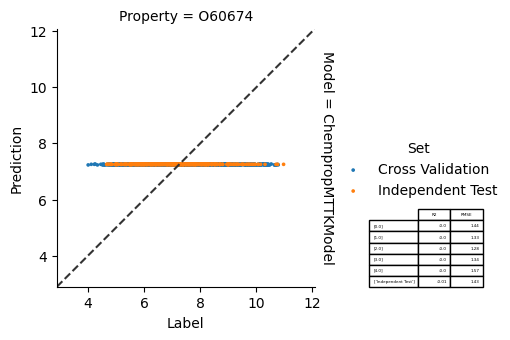

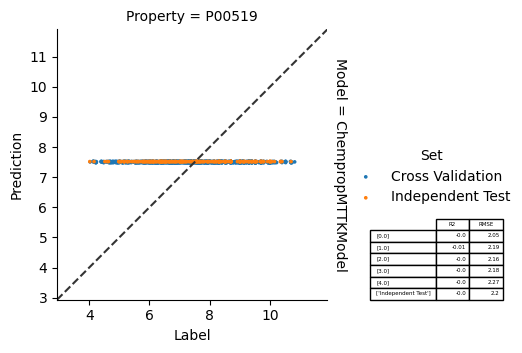

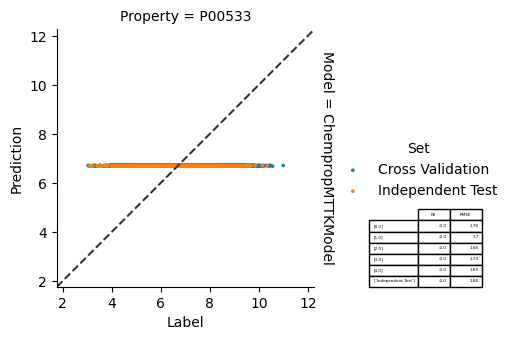

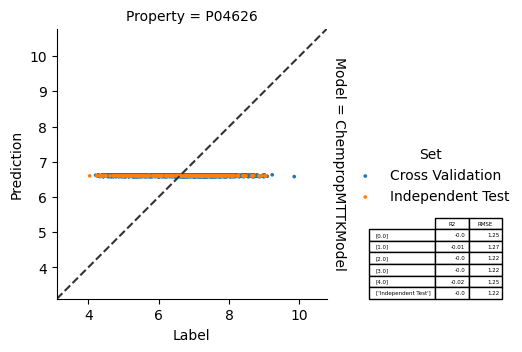

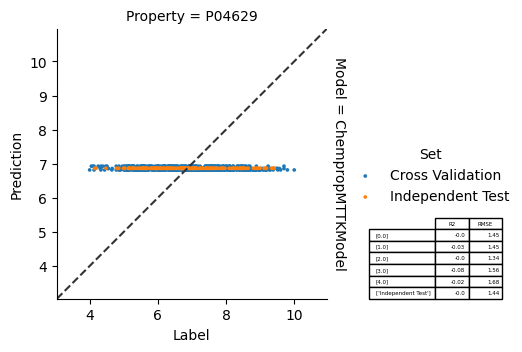

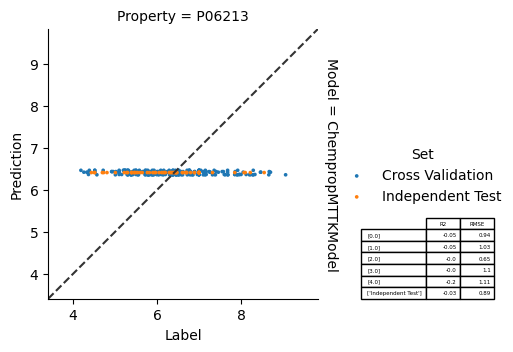

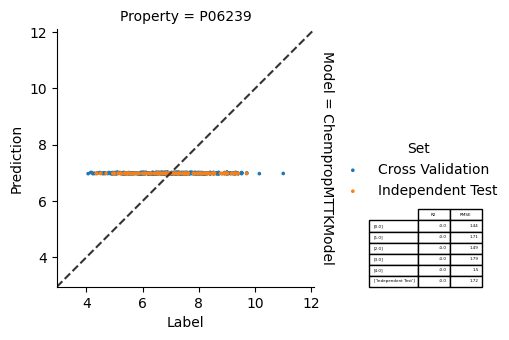

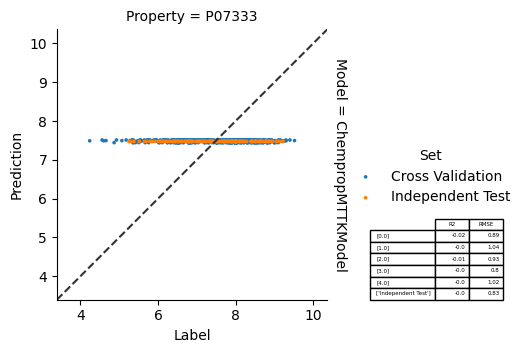

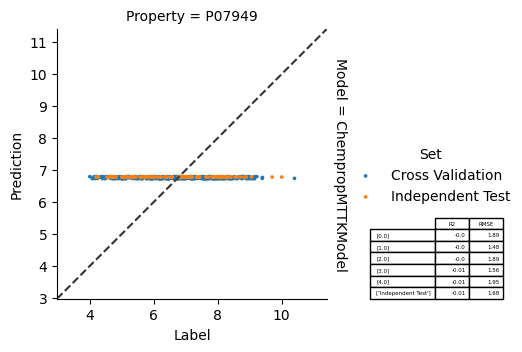

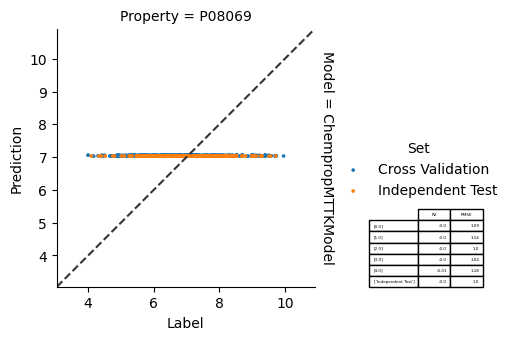

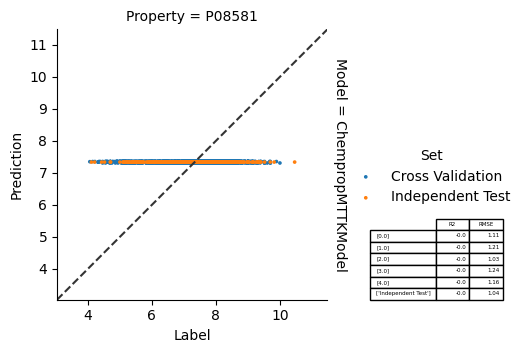

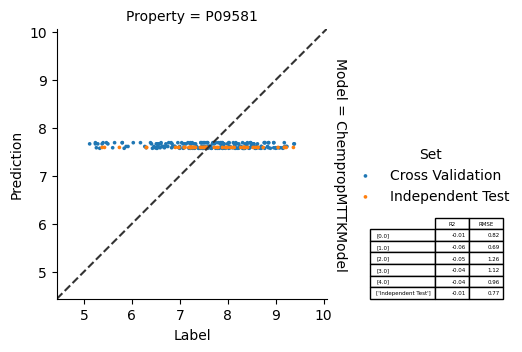

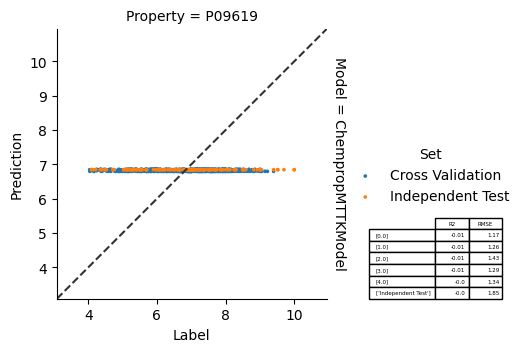

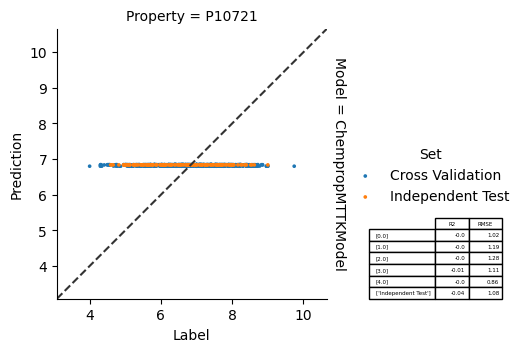

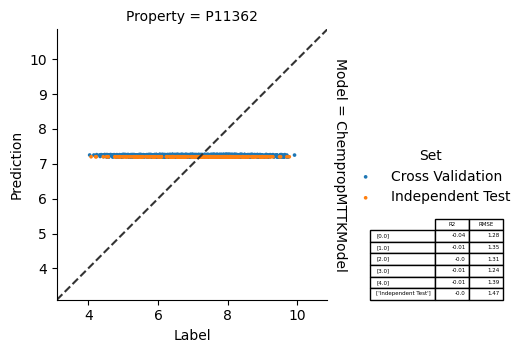

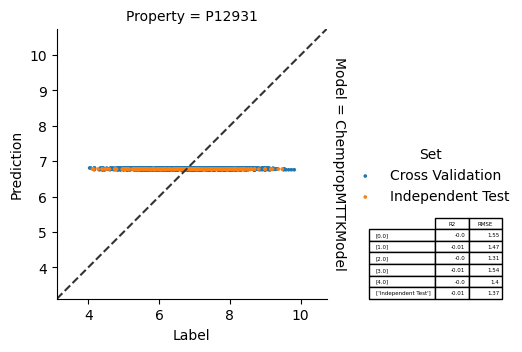

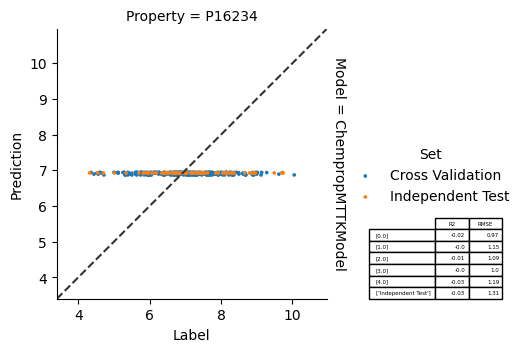

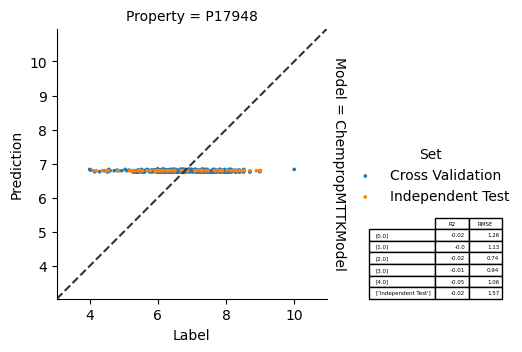

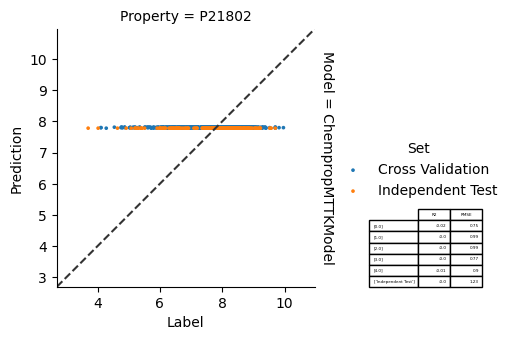

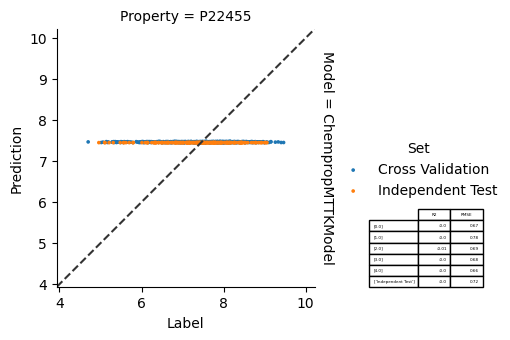

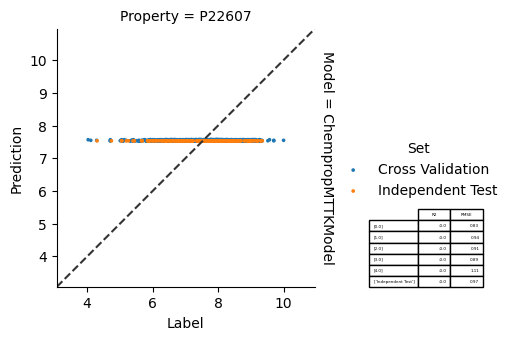

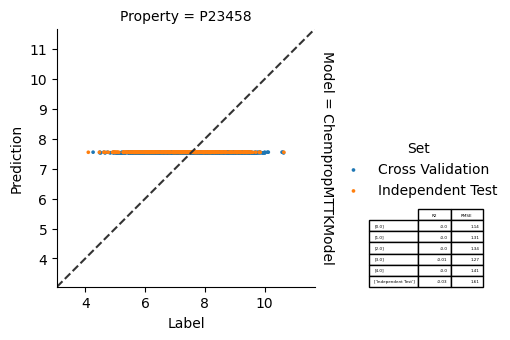

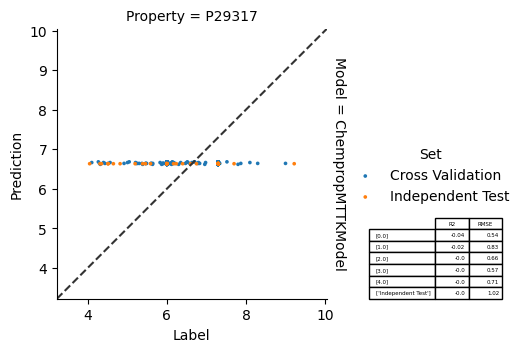

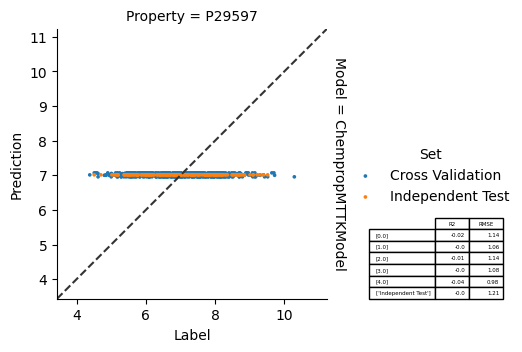

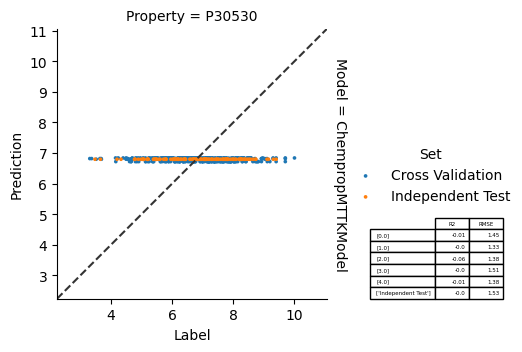

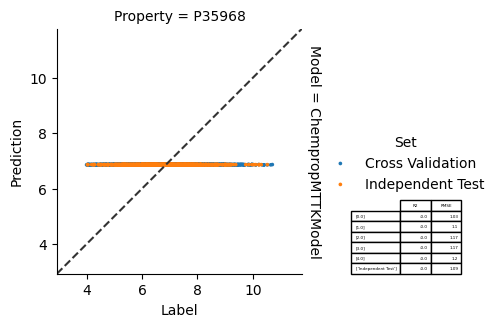

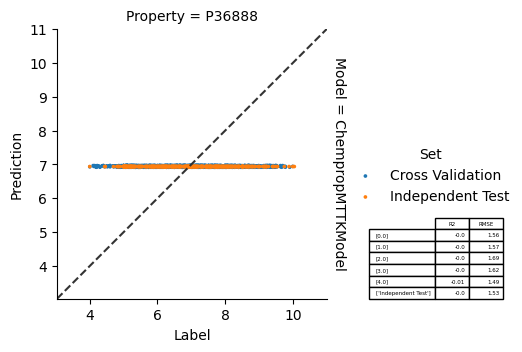

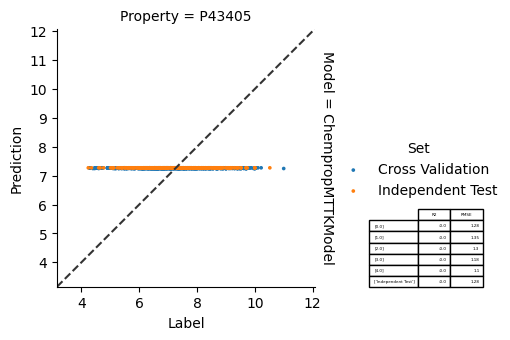

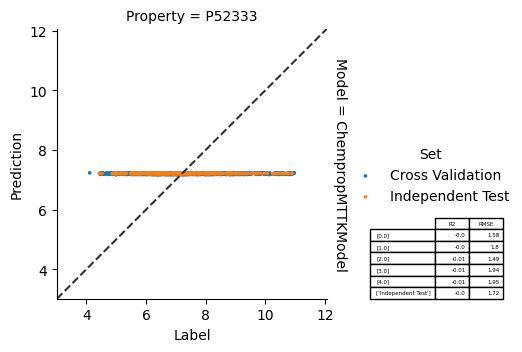

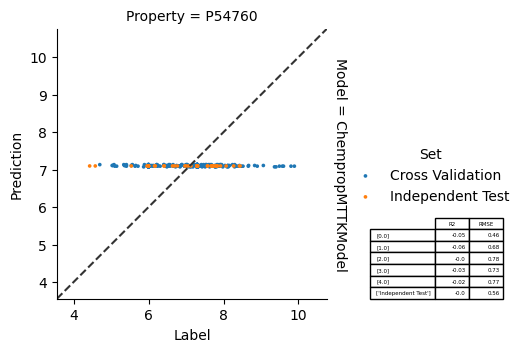

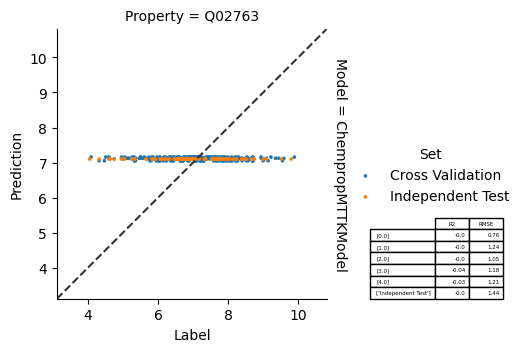

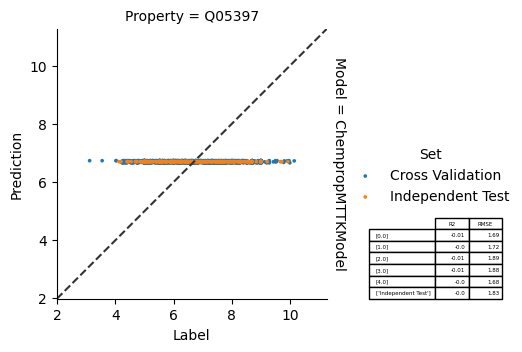

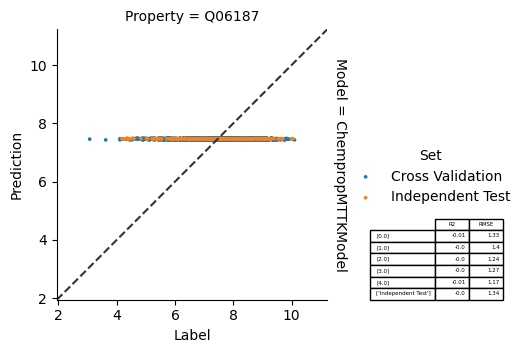

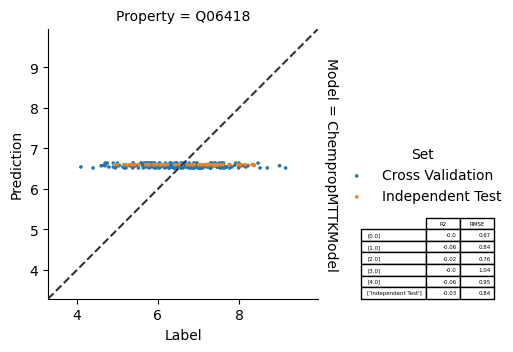

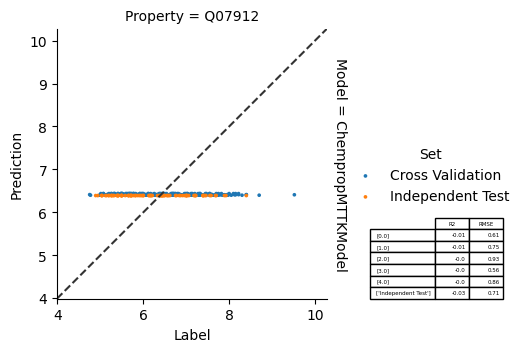

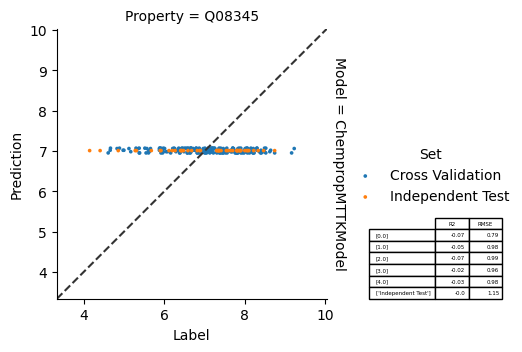

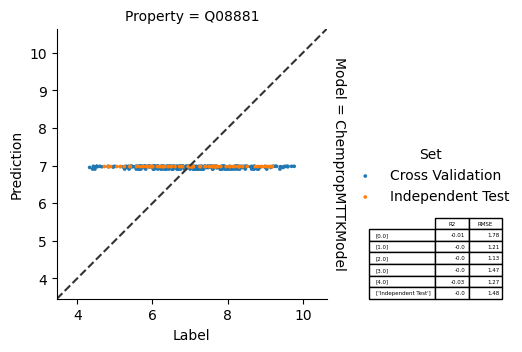

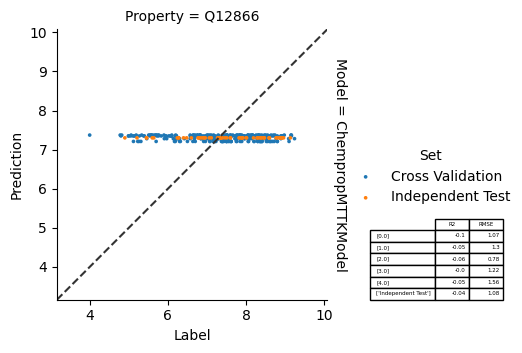

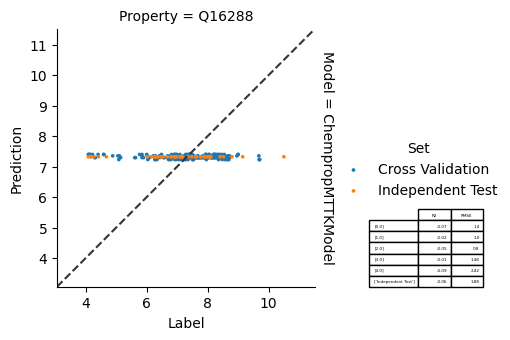

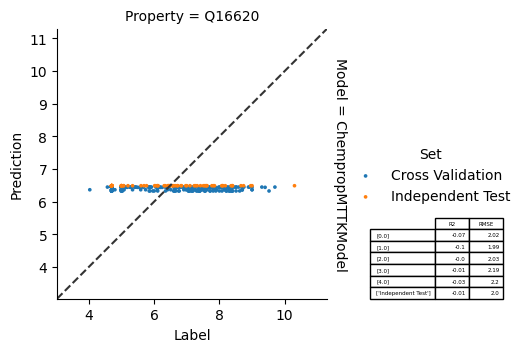

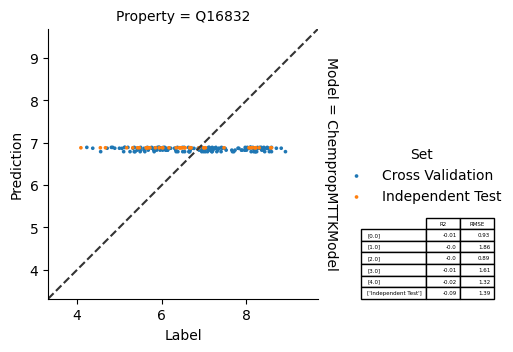

In [11]:
from plotting_regression_MT import CorrelationPlot

plot = CorrelationPlot([model])
axes, summary = plot.make(save=True, show=True, out_path='/home/s2861704/ppk/test_kin/output/TK/MTcust/ChempropMTcust.png')

In [12]:
summary

Model              Fold Property        R2      RMSE  \
0    ChempropMTTKModel               0.0   O60674 -0.002986  1.444715   
1    ChempropMTTKModel               0.0   P00519 -0.000927  2.047261   
2    ChempropMTTKModel               0.0   P00533 -0.001322  1.776912   
3    ChempropMTTKModel               0.0   P04626 -0.000044  1.247803   
4    ChempropMTTKModel               0.0   P04629 -0.000573  1.446230   
..                 ...               ...      ...       ...       ...   
241  ChempropMTTKModel  Independent Test   Q08881 -0.003817  1.476566   
242  ChempropMTTKModel  Independent Test   Q12866 -0.038919  1.075060   
243  ChempropMTTKModel  Independent Test   Q16288 -0.059877  1.880592   
244  ChempropMTTKModel  Independent Test   Q16620 -0.011904  2.002480   
245  ChempropMTTKModel  Independent Test   Q16832 -0.094822  1.388778   

                  Set  
0    Cross Validation  
1    Cross Validation  
2    Cross Validation  
3    Cross Validation  
4    Cross Validation  
..                ...  
241  Independent Test  
242  Independent Test  
243  Independent Test  
244  Independent Test  
245  Independent Test  

[246 rows x 6 columns]